In [1]:
from pyspark.sql import SparkSession

# Start Spark session
spark = SparkSession.builder.appName("Steam Reviews Analysis").getOrCreate()

25/07/11 15:55:49 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/07/11 15:55:49 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/11 15:55:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load the dataset
df = spark.read.csv("Project/clean_sample.csv", header=True, inferSchema=True)

# Preview the schema
df.printSchema()

root
 |-- app_id: integer (nullable = true)
 |-- app_name: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_votes: integer (nullable = true)



In [3]:
# Register temporary SQL view
df.createOrReplaceTempView("reviews")

In [17]:
# SQL query: negative review ratio per game
query = """
SELECT 
    app_name,
    COUNT(*) AS total_reviews,
    SUM(CASE WHEN review_score = -1 THEN 1 ELSE 0 END) AS negative_reviews,
    ROUND(
        SUM(CASE WHEN review_score = -1 THEN 1 ELSE 0 END) * 1.0 / COUNT(*),
        3
    ) AS negative_ratio
FROM reviews
WHERE app_name IS NOT NULL
GROUP BY app_name
HAVING COUNT(*) > 100
ORDER BY negative_ratio DESC
LIMIT 20
"""

# Execute the query
negative_by_game = spark.sql(query)

In [18]:
# Show the results
negative_by_game.show(truncate=False)

+--------------------------------------+-------------+----------------+--------------+
|app_name                              |total_reviews|negative_reviews|negative_ratio|
+--------------------------------------+-------------+----------------+--------------+
|Postal 3                              |579          |376             |0.649         |
|Lume                                  |302          |168             |0.556         |
|A.V.A. Alliance of Valiant Arms™      |5067         |2680            |0.529         |
|Disciples III: Reincarnation          |145          |59              |0.407         |
|A New Beginning - Final Cut           |445          |169             |0.380         |
|Super Monday Night Combat             |2457         |822             |0.335         |
|WARP                                  |138          |45              |0.326         |
|ORION: Prelude                        |11620        |3019            |0.260         |
|TimeShift                             |295

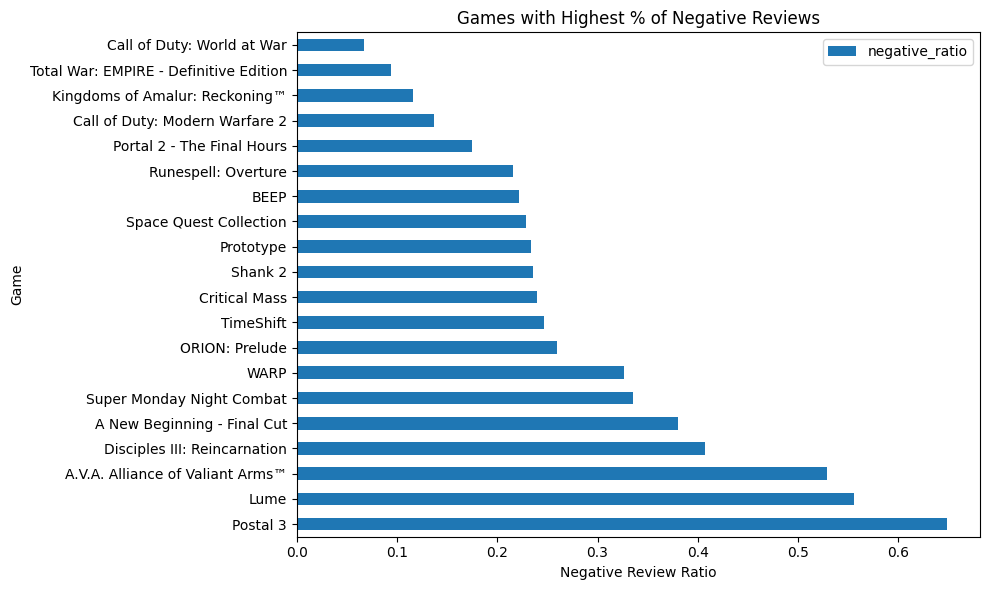

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for visualization
pdf = negative_by_game.toPandas()

# Ensure the column is numeric
pdf["negative_ratio"] = pd.to_numeric(pdf["negative_ratio"], errors="coerce")

# Sort and select top 20
pdf = pdf.sort_values(by="negative_ratio", ascending=False).head(20)

# Plot
pdf.plot(x="app_name", y="negative_ratio", kind="barh", figsize=(10, 6))
plt.title("Games with Highest % of Negative Reviews")
plt.xlabel("Negative Review Ratio")
plt.ylabel("Game")
plt.tight_layout()
plt.show()